### Table of contents


[- Data processing](#Data-processing)  
[- Neural network training and validating](#Neural-network-training-and-validating)

Neural network training and validating

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, jaccard_score, pairwise_distances
import matplotlib.pyplot as plt
import nbimporter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim


from pathlib import Path
current_path = Path().resolve()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
df_songs = pd.read_csv(current_path / 'Data/Music Info.csv')

df_users = pd.read_csv(current_path / 'Data/User Listening History.csv')

***
### Data processing 
***

- The dataset is seperated into two parts, one including the rows where genre is not available and the other dataset has the rest of the rows.

In [5]:
print("Music info dataset shape: ",df_songs.shape)
print("User listening shape: ",df_users.shape)

Music info dataset shape:  (50683, 21)
User listening shape:  (9711301, 3)


In [6]:
null_count = df_songs.isnull().sum()
null_count = null_count[null_count > 0]
print("Number of null elements in coloumn")
print(null_count)

Number of null elements in coloumn
tags      1127
genre    28335
dtype: int64


In [7]:
# Separate rows where 'genre' is NaN
df_without = df_songs[df_songs['genre'].isna()]

# Separate rows where 'genre' is not NaN. 
df_with = df_songs[df_songs['genre'].notna()]


In [8]:
df_without.shape

(28335, 21)

In [24]:
# Get the unique artist values from both datasets
unique_in_df_with = set(df_with['artist'].unique())
unique_in_df_without = set(df_without['artist'].unique())

# Find artists in df_without but not in df_with
artists_only_in_df_without = unique_in_df_without - unique_in_df_with

# Print the number of unique artists and some samples
print(f"Number of unique artists in df_without but not in df_with: {len(artists_only_in_df_without)}")
print("Sample of unique artists in df_without but not in df_with:")
print(list(artists_only_in_df_without)[:10])  # Print the first 10 artists as a sample



Number of unique artists in df_without but not in df_with: 3169
Sample of unique artists in df_without but not in df_with:
['Agent Alvin', 'John Mellencamp', 'Kendji Girac', 'Maduk', 'Woods', 'Albert Hammond', 'Clark', 'Champaign', 'Cor Scorpii', 'El Guincho']


In [29]:
print(len(df_without[df_without['artist'].isin(artists_only_in_df_without)]))

5603


***
### Neural network training and validating
***

In [11]:
# Neural Networt

# Select features for one-hot encoding (categorical features)
#categorical_features = ['playlist_name', 'track_artist']
categorical_features = ['artist']

# Apply one-hot encoding
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
onehot_encoded = onehot_encoder.fit_transform(df_with[categorical_features])

# Convert the one-hot encoded features to a DataFrame
onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(categorical_features))

# Merge the one-hot encoded features with the numerical features
numerical_features = df_with[['year','danceability', 'energy', 'tempo', 'acousticness', 'instrumentalness', 
                         'liveness', 'valence', 'loudness', 'speechiness']]

# Combine numerical and one-hot encoded categorical features
#X_combined = pd.concat([numerical_features, onehot_encoded_df], axis=1)
X_combined = pd.concat([numerical_features.reset_index(drop=True), onehot_encoded_df.reset_index(drop=True)], axis=1)

y = df_with['genre']

# Drop the first row just so we can use that song as the input song
X_combined = X_combined.drop(0).reset_index(drop=True)  # Drop the first row from X
y = y.drop(y.index[0]).reset_index(drop=True)  # Drop the first row from y, ensure to use the index

# Encode genres
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

from torch.utils.data import DataLoader, TensorDataset

# Create TensorDataset and DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64  # Set your batch size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Neural Network
class Net(nn.Module):
    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()
        
        # Input layer to first hidden layer
        self.W_1 = nn.Parameter(torch.empty(num_hidden, num_features))
        nn.init.kaiming_normal_(self.W_1)
        self.b_1 = nn.Parameter(torch.zeros(num_hidden))
        
        # First hidden layer to second hidden layer
        self.W_2 = nn.Parameter(torch.empty(num_hidden, num_hidden))
        nn.init.kaiming_normal_(self.W_2)
        self.b_2 = nn.Parameter(torch.zeros(num_hidden))
        
        # Second hidden layer to output layer
        self.W_3 = nn.Parameter(torch.empty(num_output, num_hidden))
        nn.init.kaiming_normal_(self.W_3)
        self.b_3 = nn.Parameter(torch.zeros(num_output))
        
        # Batch normalization layers
        self.batchnorm1 = nn.BatchNorm1d(num_hidden)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden)
        
        # Activation and dropout
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, x):
        # Input to first hidden layer
        x = torch.mm(x, self.W_1.t()) + self.b_1
        x = self.batchnorm1(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        # First hidden layer to second hidden layer
        x = torch.mm(x, self.W_2.t()) + self.b_2
        x = self.batchnorm2(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        # Second hidden layer to output layer
        x = torch.mm(x, self.W_3.t()) + self.b_3
        return x

# Set model parameters
num_features = X_train_tensor.shape[1]  # Number of input features
num_hidden = 128  # Number of neurons in hidden layers
num_classes = len(set(y_train))  # Number of unique genres (classes)

# Initialize the model
net = Net(num_features, num_hidden, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class classification loss
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-5 )

In [12]:
# Validation function
def validate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct_test = 0
    total_test = 0
    running_loss = 0.0

    with torch.no_grad():  # No gradient calculation for evaluation
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model(inputs)
            
            # Calculate the loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    # Calculate average loss and accuracy
    test_loss = running_loss / len(test_loader)
    test_acc = correct_test / total_test
    return test_loss, test_acc

# Training loop with validation
def train_model_with_validation(model, train_loader, test_loader, num_epochs=15):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        # Calculate training metrics
        epoch_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train
        
        #Saving the training loss:
        train_losses.append(epoch_loss)
        train_accuracies.append(train_acc)

        # Validate on the test set after each epoch
        test_loss, test_acc = validate_model(model, test_loader)

        #Saving the test loss
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        # Print results every 5 epochs
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
                  f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
            
    return train_losses, train_accuracies, test_losses, test_accuracies

# Call the training function with validation
#train_model_with_validation(net, train_loader, test_loader)

train_losses, train_accuracies, test_losses, test_accuracies = train_model_with_validation(net, train_loader, test_loader)



Epoch [1/15], Train Loss: 2.7509, Train Accuracy: 0.1826, Test Loss: 2.0567, Test Accuracy: 0.4705
Epoch [2/15], Train Loss: 1.5867, Train Accuracy: 0.5905, Test Loss: 1.4356, Test Accuracy: 0.6362
Epoch [3/15], Train Loss: 1.0676, Train Accuracy: 0.7349, Test Loss: 1.2392, Test Accuracy: 0.7004
Epoch [4/15], Train Loss: 0.8075, Train Accuracy: 0.8017, Test Loss: 1.1762, Test Accuracy: 0.7239
Epoch [5/15], Train Loss: 0.6673, Train Accuracy: 0.8305, Test Loss: 1.1661, Test Accuracy: 0.7331
Epoch [6/15], Train Loss: 0.5885, Train Accuracy: 0.8396, Test Loss: 1.1765, Test Accuracy: 0.7374
Epoch [7/15], Train Loss: 0.5390, Train Accuracy: 0.8437, Test Loss: 1.1950, Test Accuracy: 0.7394
Epoch [8/15], Train Loss: 0.5085, Train Accuracy: 0.8434, Test Loss: 1.2200, Test Accuracy: 0.7380
Epoch [9/15], Train Loss: 0.4867, Train Accuracy: 0.8430, Test Loss: 1.2447, Test Accuracy: 0.7369
Epoch [10/15], Train Loss: 0.4708, Train Accuracy: 0.8440, Test Loss: 1.2577, Test Accuracy: 0.7365
Epoch [11

In [17]:
# Define the categorical features for the input song (replace with actual values)
input_song_categorical = pd.DataFrame({
    #'playlist_name': ['Pop Remix'],  # Replace with the actual playlist name
    'track_artist': ['Ed Sheeran']      # Replace with the actual track artist
})

# Apply the same one-hot encoding as used in training
input_song_categorical_encoded = onehot_encoder.transform(categorical_features)

# Convert to DataFrame
input_song_categorical_df = pd.DataFrame(input_song_categorical_encoded, columns=onehot_encoder.get_feature_names_out(categorical_features))

# Define the numerical features for the input song (replace with actual values)
input_song_numerical = pd.DataFrame([{
    'danceability': 0.748, 'energy': 0.916, 'tempo': 122.036, 'acousticness': 0.102, 
    'instrumentalness': 0.0, 'liveness': 0.0653, 'valence': 0.518, 'loudness': -2.634, 'speechiness': 0.0583, 
}])

# Combine the one-hot encoded categorical features with the numerical features
input_song_combined = pd.concat([input_song_numerical, input_song_categorical_df], axis=1)

# Ensure the columns match the same order as the training data
input_song_combined = input_song_combined[X_combined.columns]  # Ensure same column order

# Convert to PyTorch tensor
input_song_tensor = torch.tensor(input_song_combined.values, dtype=torch.float32)

# Now use the neural network to predict the genre
net.eval()
with torch.no_grad():
    predicted_genre_tensor = net(X_combined_tensor)
    predicted_genres = torch.argmax(predicted_genre_tensor, dim=1)

# Convert the predicted genre back to its label
predicted_genre_label = label_encoder.inverse_transform([predicted_genre])
print(f"Predicted genre: {predicted_genre_label}")

ValueError: Expected 2D array, got 1D array instead:
array=['artist'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [20]:
# One-hot encode the categorical feature (track_artist) for the entire dataset
onehot_encoded = onehot_encoder.transform(df_without[['artist']])
onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(categorical_features))
onehot_encoded_df = onehot_encoded_df.reset_index(drop=True)

# Merge the one-hot encoded features with the numerical features
numerical_features = df_without[['year','danceability', 'energy', 'tempo', 'acousticness', 'instrumentalness', 
                         'liveness', 'valence', 'loudness', 'speechiness']]
numerical_features = numerical_features.reset_index(drop=True)

# Combine numerical and one-hot encoded categorical features
X_combined = pd.concat([numerical_features, onehot_encoded_df], axis=1)

print(f"Rows in df_without: {len(df_without)}")
print(f"Rows in numerical_features: {len(numerical_features)}")
print(f"Rows in onehot_encoded_df: {len(onehot_encoded_df)}")
print(f"Rows in X_combined: {len(X_combined)}")


assert len(X_combined) == len(df_without), "Mismatch between X_combined and df_without rows"

# Scale the data using the previously fitted scaler
X_combined_scaled = scaler.transform(X_combined)

# Convert the scaled data to a PyTorch tensor
X_combined_tensor = torch.tensor(X_combined_scaled, dtype=torch.float32)

net.eval()
with torch.no_grad():  # Disable gradient computation for predictions
    predicted_genre_tensor = net(X_combined_tensor)
    predicted_genres = torch.argmax(predicted_genre_tensor, dim=1)

# Convert the predicted genre indices back to genre labels
predicted_genre_label = label_encoder.inverse_transform(predicted_genres.numpy())

# Add the predicted genres as a new column in the DataFrame
df_without['predicted_genre'] = predicted_genre_label

df_without.head()


Rows in df_without: 28335
Rows in numerical_features: 28335
Rows in onehot_encoded_df: 28335
Rows in X_combined: 28335


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- artist_!!!
- artist_'Til Tuesday
- artist_1 Giant Leap
- artist_10 Ft. Ganja Plant
- artist_16bit
- ...
Feature names seen at fit time, yet now missing:
- artist_.38 Special
- artist_112
- artist_12th Planet
- artist_1990s
- artist_2 Live Crew
- ...


In [8]:
print(df[df['track_id']=='75FpbthrwQmzHlBJLuGdC7'])

                 track_id                         track_name  \
3  75FpbthrwQmzHlBJLuGdC7  Call You Mine - Keanu Silva Remix   

       track_artist  track_popularity          track_album_id  \
3  The Chainsmokers                60  1nqYsOef1yKKuGOVchbsk6   

              track_album_name track_album_release_date playlist_name  \
3  Call You Mine - The Remixes               2019-07-19     Pop Remix   

              playlist_id playlist_genre  ... key  loudness  mode  \
3  37i9dQZF1DXcZDD7cfEKhW            pop  ...   7    -3.778     1   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
3        0.102        0.0287          0.000009     0.204    0.277  121.956   

   duration_ms  
3       169093  

[1 rows x 23 columns]


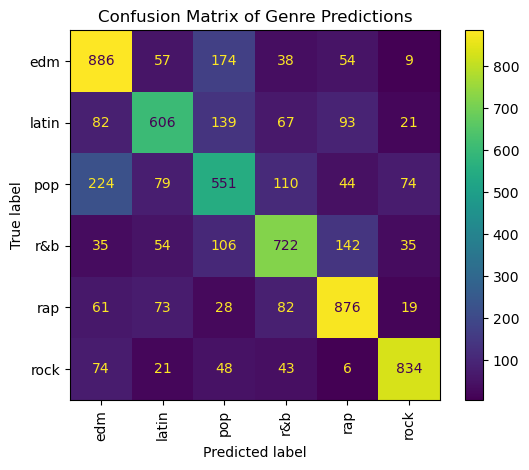

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions for all test songs
y_test_pred = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        y_test_pred.extend(predicted.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=90)
plt.title("Confusion Matrix of Genre Predictions")
plt.show()


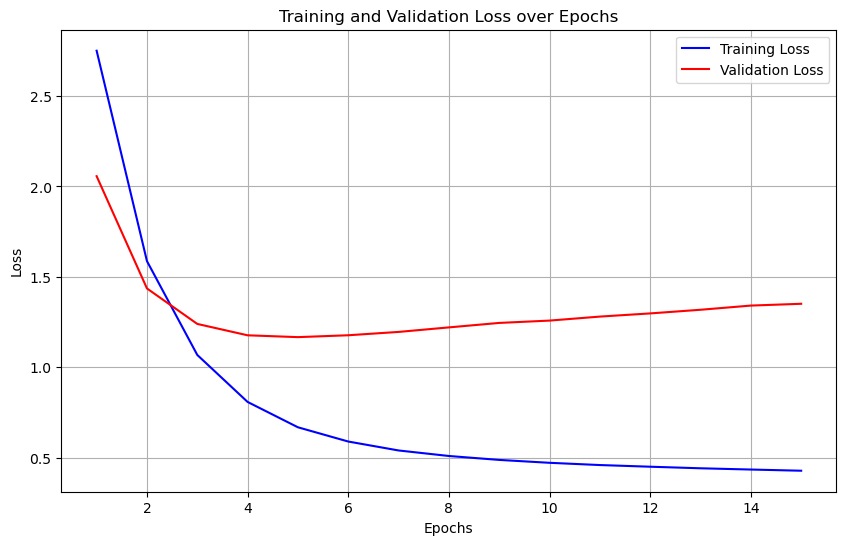

In [21]:
#Visualizing the training and test loss
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, test_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Cluster with k-means

In [19]:
# Cluster all songs with that genre

# Filter the dataset for songs of the predicted genre
filtered_songs = df[df['playlist_genre'] == predicted_genre_label[0]]

# Select the features for clustering
features_for_clustering = ['track_popularity', 'danceability', 'energy', 'key', 'loudness', 
                           'mode', 'speechiness', 'acousticness', 'instrumentalness', 
                           'liveness', 'valence', 'tempo', 'duration_ms']

# Extract the features from the filtered dataset
X_genre_songs = filtered_songs[features_for_clustering]

# Standardize the features
scaler = StandardScaler()
X_genre_scaled = scaler.fit_transform(X_genre_songs)

# Perform clustering (using k-means with 5 clusters as an example)
kmeans = KMeans(n_clusters=5, random_state=42)
filtered_songs['cluster'] = kmeans.fit_predict(X_genre_scaled)

input_song_clustering = torch.tensor([[66, 0.748, 0.916, 6, -2.634, 1, 0.0583, 0.102, 0.0, 0.0653, 0.518, 122.036, 194754]], dtype=torch.float32)

# Scale the input song's features (same scaler used before)
input_song_scaled = scaler.transform(input_song_clustering)

# Predict the cluster for the input song
input_song_cluster = kmeans.predict(input_song_scaled)[0]
print(f"The input song belongs to cluster: {input_song_cluster}")

c:\Users\alexj\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The input song belongs to cluster: 2


C:\Users\alexj\AppData\Local\Temp\ipykernel_8956\466298237.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_songs['cluster'] = kmeans.fit_predict(X_genre_scaled)
c:\Users\alexj\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


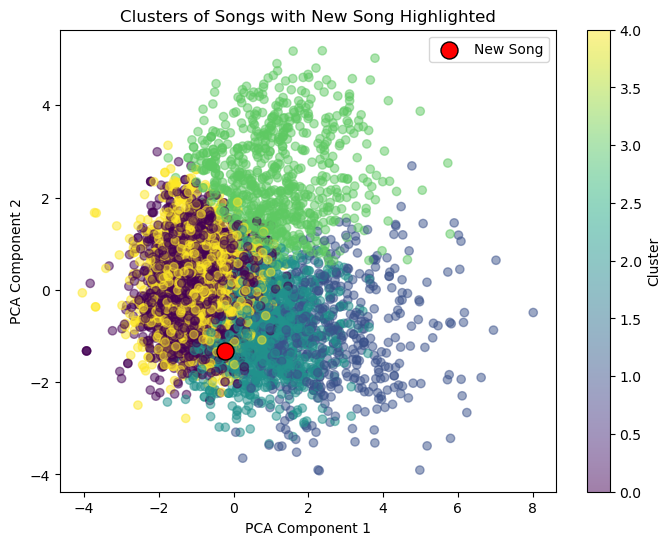

Intra-cluster Similarity (Compactness) for each cluster: [2.750443567471476, 3.7810244996092046, 2.940135939071547, 3.200291343737384, 2.806474724427631]
Inter-cluster Separation (Distance between centroids):
 [[0.         4.11691903 2.56273646 3.53633206 2.04533249]
 [4.11691903 0.         3.29688639 4.29179814 4.09557563]
 [2.56273646 3.29688639 0.         3.47637858 2.4492797 ]
 [3.53633206 4.29179814 3.47637858 0.         3.41065801]
 [2.04533249 4.09557563 2.4492797  3.41065801 0.        ]]
Davies-Bouldin Index: 2.3169936230012795


In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce the dimensionality of the scaled features to 2D for visualization
pca = PCA(n_components=2)
X_genre_pca = pca.fit_transform(X_genre_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_genre_pca[:, 0], X_genre_pca[:, 1], c=filtered_songs['cluster'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster')

# Apply PCA to the new song's features
input_song_pca = pca.transform(input_song_scaled)

# Plot the new input song
plt.scatter(input_song_pca[0, 0], input_song_pca[0, 1], color='red', edgecolor='black', s=150, label='New Song')
plt.title('Clusters of Songs with New Song Highlighted')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# Step 4: Evaluate Clusters using Davies-Bouldin Index
centroids = kmeans.cluster_centers_
intra_cluster_similarity = []
for i in range(len(centroids)):
    # Filter points belonging to cluster i
    cluster_points = X_genre_scaled[filtered_songs['cluster'] == i]
    
    # Calculate average distance of points to the cluster centroid
    avg_distance = np.mean(pairwise_distances(cluster_points, [centroids[i]]))
    intra_cluster_similarity.append(avg_distance)

print("Intra-cluster Similarity (Compactness) for each cluster:", intra_cluster_similarity)

inter_cluster_separation = np.zeros((len(centroids), len(centroids)))

for i in range(len(centroids)):
    for j in range(len(centroids)):
        if i != j:  # Don't calculate for the same cluster
            # Calculate distance between centroids of cluster i and cluster j
            inter_cluster_separation[i, j] = np.linalg.norm(centroids[i] - centroids[j])

print("Inter-cluster Separation (Distance between centroids):\n", inter_cluster_separation)

dbi_score = davies_bouldin_score(X_genre_scaled, filtered_songs['cluster'])

dbi_list = []
for i in range(len(centroids)):
    max_ratio = 0
    for j in range(len(centroids)):
        if i != j:
            # Ratio of (intra-cluster similarity of i + intra-cluster similarity of j) / inter-cluster separation
            ratio = (intra_cluster_similarity[i] + intra_cluster_similarity[j]) / inter_cluster_separation[i, j]
            max_ratio = max(max_ratio, ratio)
    dbi_list.append(max_ratio)

# The final Davies-Bouldin Index is the average of these max ratios
davies_bouldin_index = np.mean(dbi_list)
print("Davies-Bouldin Index:", davies_bouldin_index)


In [28]:
# Assuming `filtered_songs` contains numeric data for the songs
# Filter numeric features only (no categorical data)
numeric_lsh_features = ['track_popularity', 'danceability', 'energy', 'key', 'loudness',
                        'mode', 'speechiness', 'acousticness', 'instrumentalness', 
                        'liveness', 'valence', 'tempo', 'duration_ms']

# Step 1: Convert continuous features to binary using threshold (example: median)
binary_songs = filtered_songs[numeric_lsh_features].copy()  # Apply only to numeric features
for feature in numeric_lsh_features:
    binary_songs[feature] = (filtered_songs[feature] > filtered_songs[feature].median()).astype(int)

# Step 2: Binary features for the input song (same transformation)
# Flatten the input song clustering array to ensure consistent shape
input_song_clustering_np = input_song_clustering.numpy().flatten()  # Convert to NumPy and flatten to 1D

# Now compare
binary_input_song = (input_song_clustering_np > filtered_songs[numeric_lsh_features].median()).astype(int)

# Function to compute Jaccard similarity for each song in the cluster
def jaccard_similarity(song1, song2):
    return jaccard_score(song1, song2, average='weighted')

# Step 3: Compute Jaccard similarity for all songs in the cluster
similarity_scores = binary_songs.apply(lambda song: jaccard_similarity(binary_input_song[numeric_lsh_features], song), axis=1)

# Step 4: Get the indices of the top 5 most similar songs
top_5_similar_songs_indices = similarity_scores.nlargest(5).index

# Step 5: Recommend the top 5 songs
recommended_songs = filtered_songs.loc[top_5_similar_songs_indices, ['track_name', 'track_artist']]
print(recommended_songs)

                                       track_name    track_artist
27338                                 Black Betty  Caravan Palace
27573                 Not Ok - Frank Walker Remix            Kygo
27641                          Came Here for Love          Sigala
28651                 Not Ok - Frank Walker Remix            Kygo
29669  You Need To Calm Down - Clean Bandit Remix    Taylor Swift
